In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import glob
import os
import time
import json
import copy
import random
import cv2
from IPython.display import display

In [2]:
plt.style.use('seaborn')
warnings.filterwarnings('ignore')

In [3]:
# File:
root = r'D:\桌面\基於深度學習之視覺辨識專論'
trainPath = os.path.join(root, 'training_data')
testPath = os.path.join(root, 'testing_data')
labelPath = os.path.join(root, 'training_labels.csv')

# Model:
imgSize = (224, 224, 3)
batchSize = 128
epochs = 100
initLR = 0.001


In [4]:
def ChangeRoot(df, root):
    df['path'] = df['path'].apply(lambda x: os.path.join(root, os.path.split(x)[-1]))
    return df


trainImgPaths = ChangeRoot(pd.read_csv(os.path.join(root, 'trainImgPaths.csv')), trainPath)
validImgPaths = ChangeRoot(pd.read_csv(os.path.join(root, 'validImgPaths.csv')), trainPath)

print('validImgPaths: ')
display(validImgPaths)
print('trainImgPaths: ')
display(trainImgPaths)


validImgPaths: 


,path,label
0,D:\桌面\基於深度學習之視覺辨識專論\training_data\014427.jpg,Rolls-Royce Ghost Sedan 2012
1,D:\桌面\基於深度學習之視覺辨識專論\training_data\004783.jpg,Chevrolet Camaro Convertible 2012
2,D:\桌面\基於深度學習之視覺辨識專論\training_data\014391.jpg,Rolls-Royce Phantom Drophead Coupe Convertible...
3,D:\桌面\基於深度學習之視覺辨識專論\training_data\015652.jpg,Volkswagen Golf Hatchback 2012
4,D:\桌面\基於深度學習之視覺辨識專論\training_data\015225.jpg,Tesla Model S Sedan 2012
...,...,...
1113,D:\桌面\基於深度學習之視覺辨識專論\training_data\012016.jpg,Jeep Wrangler SUV 2012
1114,D:\桌面\基於深度學習之視覺辨識專論\training_data\002043.jpg,Audi TT RS Coupe 2012
1115,D:\桌面\基於深度學習之視覺辨識專論\training_data\010130.jpg,Geo Metro Convertible 1993
1116,D:\桌面\基於深度學習之視覺辨識專論\training_data\009175.jpg,Ford GT Coupe 2006


trainImgPaths: 


,path,label
0,D:\桌面\基於深度學習之視覺辨識專論\training_data\014819.jpg,Spyker C8 Coupe 2009
1,D:\桌面\基於深度學習之視覺辨識專論\training_data\014775.jpg,Spyker C8 Coupe 2009
2,D:\桌面\基於深度學習之視覺辨識專論\training_data\014833.jpg,Spyker C8 Coupe 2009
3,D:\桌面\基於深度學習之視覺辨識專論\training_data\014887.jpg,Suzuki Aerio Sedan 2007
4,D:\桌面\基於深度學習之視覺辨識專論\training_data\014821.jpg,Spyker C8 Coupe 2009
...,...,...
10062,D:\桌面\基於深度學習之視覺辨識專論\training_data\000372.jpg,Acura TSX Sedan 2012
10063,D:\桌面\基於深度學習之視覺辨識專論\training_data\000364.jpg,Acura TSX Sedan 2012
10064,D:\桌面\基於深度學習之視覺辨識專論\training_data\000272.jpg,Acura TL Type-S 2008
10065,D:\桌面\基於深度學習之視覺辨識專論\training_data\000266.jpg,Acura TL Type-S 2008


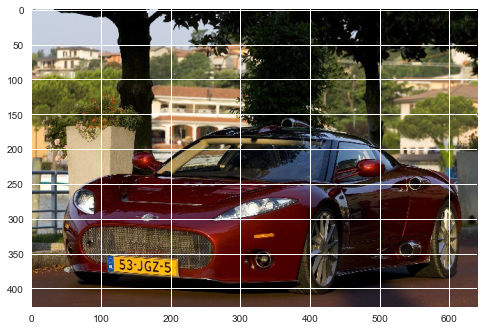

In [10]:
temp = trainImgPaths[trainImgPaths['label'] == 'Spyker C8 Coupe 2009']
i = random.choice(temp.index)
plt.imshow(plt.imread(temp.loc[i, 'path']))

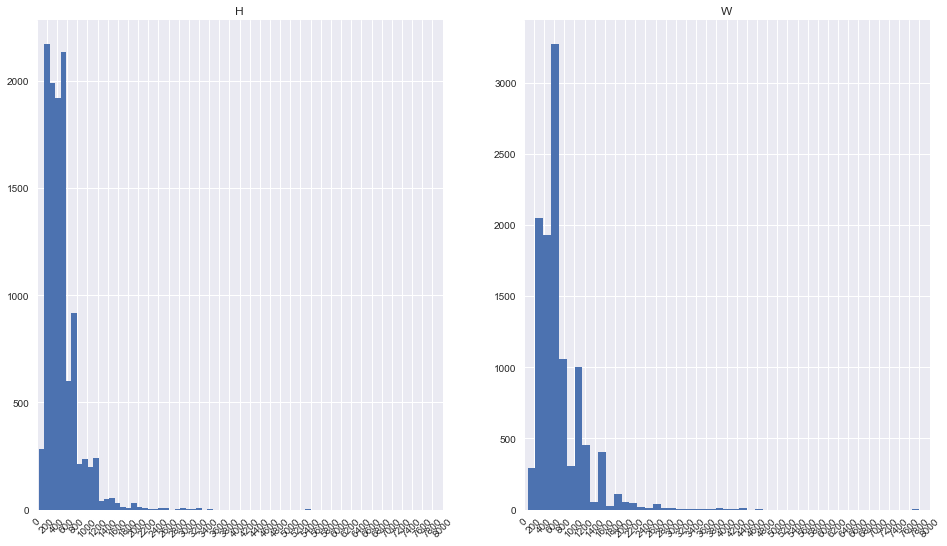

In [13]:
def PlotImageSizeDist(df, pathColumn='path'):
    h = []
    w = []
    for path in df[pathColumn]:
        img = plt.imread(path)
        h.append(img.shape[0])
        w.append(img.shape[1])
    
    plt.figure(figsize=(16, 9))
    plt.subplot(121); plt.hist(h, 50); plt.title('H'); plt.xticks(range(0, 8001, 200), rotation=45); plt.xlim([0, 8000])
    plt.subplot(122); plt.hist(w, 50); plt.title('W'); plt.xticks(range(0, 8001, 200), rotation=45); plt.xlim([0, 8000])


PlotImageSizeDist(pd.concat([trainImgPaths, validImgPaths], axis=0))


In [29]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization
from tensorflow.keras.layers import Flatten, LeakyReLU, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
#-------------------------------------------------------------------------------
trainImgGen = ImageDataGenerator(rotation_range=180,
                                 shear_range=0.3, 
                                 zoom_range=0.3,
                                 width_shift_range=0.3,
                                 height_shift_range=0.3,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 channel_shift_range=30,
                                 brightness_range=[0.6, 1.],
                                 preprocessing_function=preprocess_input)
trainImgFlow = trainImgGen.flow_from_dataframe(dataframe=trainImgPaths, 
                                                x_col='path', 
                                                y_col='label', 
                                                target_size=imgSize[:2], 
                                                batch_size=batchSize, 
                                                interpolation='bilinear')

#-------------------------------------------------------------------------------
validImgGen = ImageDataGenerator(preprocessing_function=preprocess_input)
validImgFlow = validImgGen.flow_from_dataframe(dataframe=validImgPaths, 
                                                x_col='path',
                                                y_col='label',
                                                classes=trainImgFlow.class_indices,
                                                target_size=imgSize[:2], 
                                                batch_size=batchSize, 
                                                interpolation='bilinear')

#-------------------------------------------------------------------------------

with open(os.path.join(root, f'encodes.json'), 'w', encoding='utf-8') as f:
    json.dump(trainImgFlow.class_indices, f, ensure_ascii=False)




Found 10067 validated image filenames belonging to 196 classes.
Found 1118 validated image filenames belonging to 196 classes.


[0.001, 0.0003659194809945982, 0.00034541183023802964, 0.001, 0.00029982089685174056, 0.00027540856814381866, 0.001, 0.00022557476551219119, 0.0002011336109695871, 0.0007105062677169657, 0.00015543799049600148, 0.00013486161937514078, 0.0004643654202509395, 9.922364620112238e-05, 8.426880085157519e-05, 0.00028467072039097734, 5.981033621462654e-05, 5.005390798773008e-05, 0.00016695228957438226, 3.46972706727691e-05, 2.8769618345921302e-05, 9.521134850108695e-05, 1.965775023394179e-05, 1.6209927802060183e-05, 5.340008307317068e-05, 1.0983230254040928e-05, 1e-05, 2.9663940982339046e-05, 1e-05, 1e-05, 1.6389595360527095e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05,

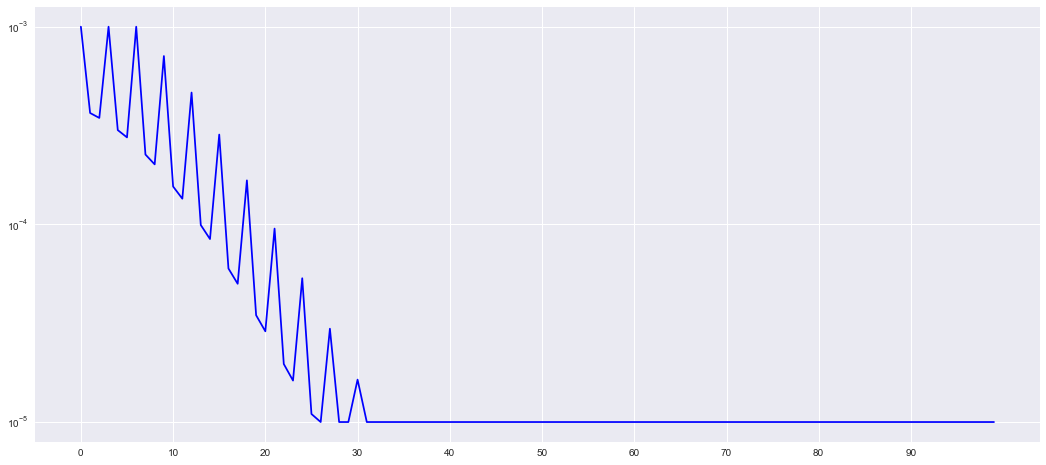

In [36]:
class CosineLRScheduler:
    def __init__(self, period=30, maxLR=0.001, minLR=1e-5, noise=True):
        self.period = period
        self.maxLR = maxLR
        self.minLR = minLR
        self.nowEpoch = 0
        
        if noise:
            self.AddNoise = lambda x: x + (np.random.random() * 2 - 1) * minLR * 0.5
        else:
            self.AddNoise = lambda x: x


    def __call__(self, epoch, lr):
        return self.GetLearningRate(epoch, lr)
    
    
    def GetLearningRate(self, epoch, lr):
        step = self.nowEpoch % self.period
        if not step == 0:
            cosineDecay = 0.5 * (1 + np.cos(np.pi * step / self.period))
            decayed = (1 - self.minLR) * cosineDecay + self.minLR
            lr = self.AddNoise(self.maxLR * decayed)

        self.nowEpoch += 1
        return lr


class PeriodDecayScheduler:
    def __init__(self, period=3, maxLR=0.001, minLR=1e-5, noise=True):
        self.period = period
        self.maxLR = maxLR
        self.minLR = minLR
        self.nowEpoch = 0
        
        if noise:
            self.AddNoise = lambda x: x + (np.random.random() * 2 - 1) * minLR * 0.5
        else:
            self.AddNoise = lambda x: x


    def __call__(self, epoch, lr):
        return self.GetLearningRate(epoch, lr)
    
    
    def GetLearningRate(self, epoch, lr):
        if not self.nowEpoch == 0:
            periodic = self.maxLR * np.cos((2 / self.period) * np.pi * self.nowEpoch) + self.maxLR
            decay = 1 / (1 + 0.1 * np.exp(self.nowEpoch) ** 0.2)
            lr = self.AddNoise(periodic * decay)
            lr = np.clip(lr, self.minLR, self.maxLR)

        self.nowEpoch += 1
        return lr 


class SaveLocalMinimunModel(tf.keras.callbacks.Callback):
    def __init__(self, period):
        self.period = period
        return super().__init__()

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.period == 0:
            filename = os.path.join(root, f"SnapshotModel_{epoch}_{round(logs['acc'], 2)}.h5")
            self.model.save(filename)
            print('\n' + '-' * 50)
            print(f'Save a model named {filename}')
            print('-' * 50 + '\n')



def PlotSchedular(scheduler, epochs, initLR):
    lrs = []
    for epoch in range(epochs):
        if lrs:
            lrs.append(scheduler(epoch, lrs[-1]))
        else:
            lrs.append(scheduler(epoch, initLR))
    
    print(lrs)
    plt.figure(figsize=(18, 8))
    plt.plot(range(epochs), lrs, 'b-')
    plt.xticks(range(0, epochs, 10))
    plt.yscale('log')


PlotSchedular(Scheduler, epochs, 0.001)


In [30]:
net = DenseNet121(include_top=False, input_shape=imgSize)
for layer in net.layers[:int(len(net.layers) * 0.5)]:
    layer.trainable = False


In [31]:
input_ = Input(shape=imgSize)
x = net.call(input_, training=False)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(196, activation = "softmax", kernel_regularizer=l2(0.001))(x)

classifier = Model(inputs = [input_], outputs = [x])
classifier.compile(loss = "categorical_crossentropy", optimizer = Adam(initLR), metrics = ["acc"])
classifier.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 1024)        4096      
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 196)               200900    
Total params: 7,242,500
Trainable params: 2,259,396
Non-trainable params: 4,983,104
_________________________________________________________________


In [48]:
scheduler = LearningRateScheduler(PeriodDecayScheduler(epochs//10, initLR), verbose=0)
checkpoints = ModelCheckpoint(os.path.join(root, 'densenet121_{epoch:03d}_{val_acc:.2f}.h5'), monitor='val_acc')

In [51]:
history =  classifier.fit(x=trainImgFlow, 
                        steps_per_epoch=trainImgFlow.n//batchSize,
                        epochs=5,
                        validation_data=validImgFlow,
                        validation_steps=validImgFlow.n//batchSize,
                        callbacks=[checkpoints, scheduler])

Epoch 1/5
78/78 [==============================] - 199s 3s/step - loss: 0.4197 - acc: 0.9598 - val_loss: 0.7329 - val_acc: 0.8447
Epoch 2/5
78/78 [==============================] - 199s 3s/step - loss: 0.4146 - acc: 0.9605 - val_loss: 0.7385 - val_acc: 0.8438
Epoch 3/5
78/78 [==============================] - 202s 3s/step - loss: 0.4154 - acc: 0.9619 - val_loss: 0.7245 - val_acc: 0.8457
Epoch 4/5
78/78 [==============================] - 199s 3s/step - loss: 0.4179 - acc: 0.9608 - val_loss: 0.7435 - val_acc: 0.8447
Epoch 5/5
78/78 [==============================] - 202s 3s/step - loss: 0.4063 - acc: 0.9638 - val_loss: 0.7171 - val_acc: 0.8477
